In [421]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [422]:
import pandas as pd
#raw = pd.pandas.read_csv('20170101_raw.csv',sep=";")
raw = pd.pandas.read_csv('20180608_raw_geo.csv',sep=",",low_memory=False)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats
print("imported " + str(len(raw)) + " rows")
#raw.columns.tolist()

imported 60503 rows


In [423]:
##############################
####    var cleaning     #####
##############################
input = ['living_area','sold_price']
clean = raw
clean = clean[pd.notnull(raw[input]).all(axis=1)] #rowsum booleans for nullvals in col
#clean = raw[pd.notnull(raw['living_area']) & pd.notnull(raw['rooms']) & pd.notnull(raw['floor']) & pd.notnull(raw['sold_price']) & pd.notnull(raw['min_distance_to_metro'])]
print("Removed " +str(len(raw)-len(clean)) + " rows with nulls")


##############################
#### additional features #####
##############################
sqm_price =  pd.DataFrame({'sqm_price':clean.sold_price / clean.living_area}) 
sqm_rent =  pd.DataFrame({'sqm_rent':clean.rent / clean.living_area})
clean = pd.concat([clean , sqm_price, sqm_rent], axis=1)

# time features
#https://pandas.pydata.org/pandas-docs/stable/timeseries.html
sold_datetime =  pd.DataFrame({'sold_datetime': pd.to_datetime(clean['sold_date'])})
published_datetime =  pd.DataFrame({'published_datetime': pd.to_datetime(clean['published'])})
clean = pd.concat([clean , sold_datetime,published_datetime], axis=1)

sold_year = pd.DataFrame({'sold_year': clean['sold_datetime'].dt.year})
sold_month_nbr = pd.DataFrame({'sold_month_nbr': clean['sold_datetime'].dt.month})
sold_year_month = pd.DataFrame({'sold_year_month': clean['sold_datetime'].dt.to_period('M')})
def get_week(row): return row['sold_datetime'].isocalendar()[1]
sold_week = pd.DataFrame({'sold_week': clean.apply(get_week, axis=1)})

def get_days_on_market(row): return (row['sold_datetime'] - row['published_datetime']).days
days_on_market = pd.DataFrame({'days_on_market': clean.apply(get_days_on_market, axis=1)})
def weekday(row): return (row.dayofweek)
sold_weekday = pd.DataFrame({'sold_weekday': clean['sold_datetime'].apply(weekday)})
published_weekday = pd.DataFrame({'published_weekday': clean['published_datetime'].apply(weekday)})



clean = pd.concat([clean , sold_year,sold_month_nbr,sold_year_month, sold_week,days_on_market,sold_weekday,published_weekday], axis=1)

##############################
####   remove outliers   #####
##############################
#remove june 2018 transactions
clean = clean[clean.sold_datetime < '2018-06-01']

num = len(clean)
before = num
important_vars = ['living_area','floor','sqm_price','distance_ocean','sqm_rent','construction_year','days_on_market']
for i in important_vars:
    q_u = clean[i].quantile(0.995)
    q_l = clean[i].quantile(0.005)
    clean = clean[(clean[i] < q_u) | (pd.isnull(clean[i]))]
    clean = clean[(clean[i] > q_l) | (pd.isnull(clean[i]))]
    print(str(round(q_l,1)) + "\t < var < \t" + str(round(q_u,1)) + ". "+ i + ' - ' + str(num - len(clean)) + " removed.")
    num = len(clean)
print("bedore: " + str(before) + ", after: " + str(len(clean)))

Removed 145 rows with nulls
19.5	 < var < 	175.0. living_area - 613 removed.
0.0	 < var < 	12.0. floor - 2071 removed.
29378.0	 < var < 	130569.2. sqm_price - 574 removed.
198.0	 < var < 	7560.7. distance_ocean - 526 removed.
14.4	 < var < 	87.7. sqm_rent - 552 removed.
1879.0	 < var < 	2017.0. construction_year - 769 removed.
0.0	 < var < 	159.0. days_on_market - 649 removed.
bedore: 60037, after: 54283


## Variable Plot

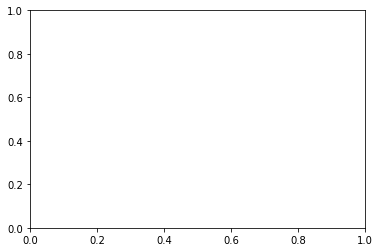

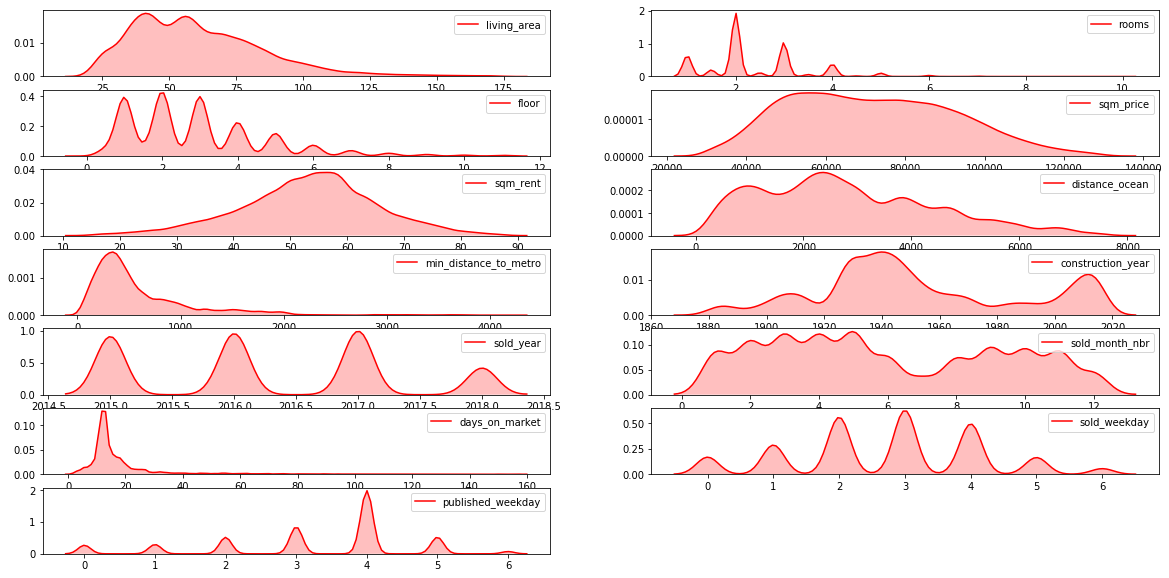

In [424]:
plot_vars = ['living_area','rooms','floor','sqm_price','sqm_rent','distance_ocean','min_distance_to_metro','construction_year','sold_year','sold_month_nbr','days_on_market','sold_weekday','published_weekday']


plt.subplots(figsize=(20,10))
for i in range(1,len(plot_vars)+1):
    data = clean[pd.notnull(clean[plot_vars[i-1]])][plot_vars[i-1]] # remove null values for the var plot
    plt.subplot(math.ceil(len(plot_vars)/2),2,i)
    sns.kdeplot(data,shade=True, color="r", bw='scott')#bw=math.sqrt(len(clean[plot_vars[i-1]].unique()))/10)

plt.show()

## Timeseries Plots

In [428]:
##define plot function and top 10 areas

#http://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.core.groupby.DataFrameGroupBy.plot.html
def timeseries_plot(plot_data,title,x_lab, y_lab):
    plt.plot(plot_data)
    plt.title(title)
    plt.ylabel(y_lab)
    plt.xlabel(x_lab)
    plt.legend(list(plot_data.columns.values))
    
areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values

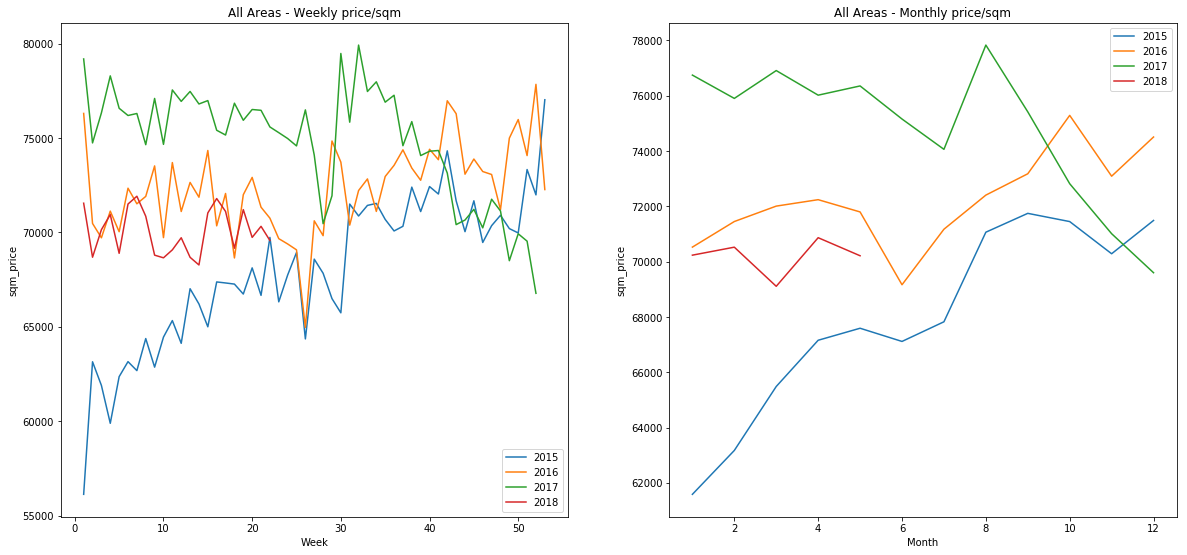

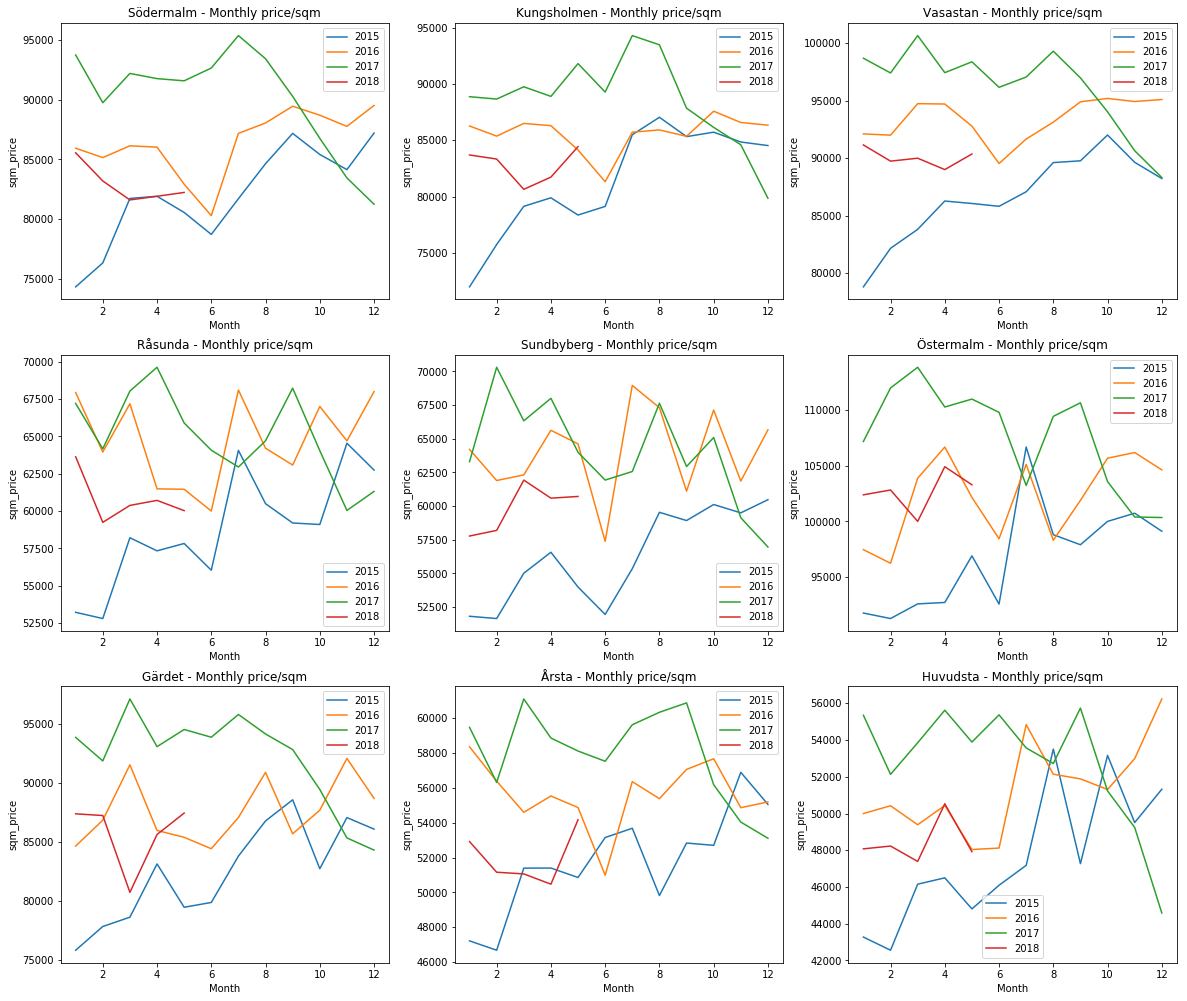

In [429]:
plt.subplots(figsize=(20,20))
plt.subplot(2,2,1)
timeseries_plot(clean.groupby(['sold_week','sold_year']).mean()['sqm_price'].unstack(),"All Areas - Weekly price/sqm", "Week", "sqm_price")
plt.subplot(2,2,2)
timeseries_plot(clean.groupby(['sold_month_nbr','sold_year']).mean()['sqm_price'].unstack(),"All Areas - Monthly price/sqm", "Month", "sqm_price")


areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    plot_data = clean[(clean.area_from_geo == areas[i])].groupby(['sold_month_nbr','sold_year']).median()['sqm_price'].unstack()
    #plot_data = clean[(clean.area_from_geo == areas[i]) & (clean.living_area < 65) & (clean.living_area > 30) ].groupby(['month_nbr','year']).mean()['sqm_price'].unstack()
    timeseries_plot(plot_data, areas[i] + " - Monthly price/sqm", "Month", "sqm_price")
    
plt.show()



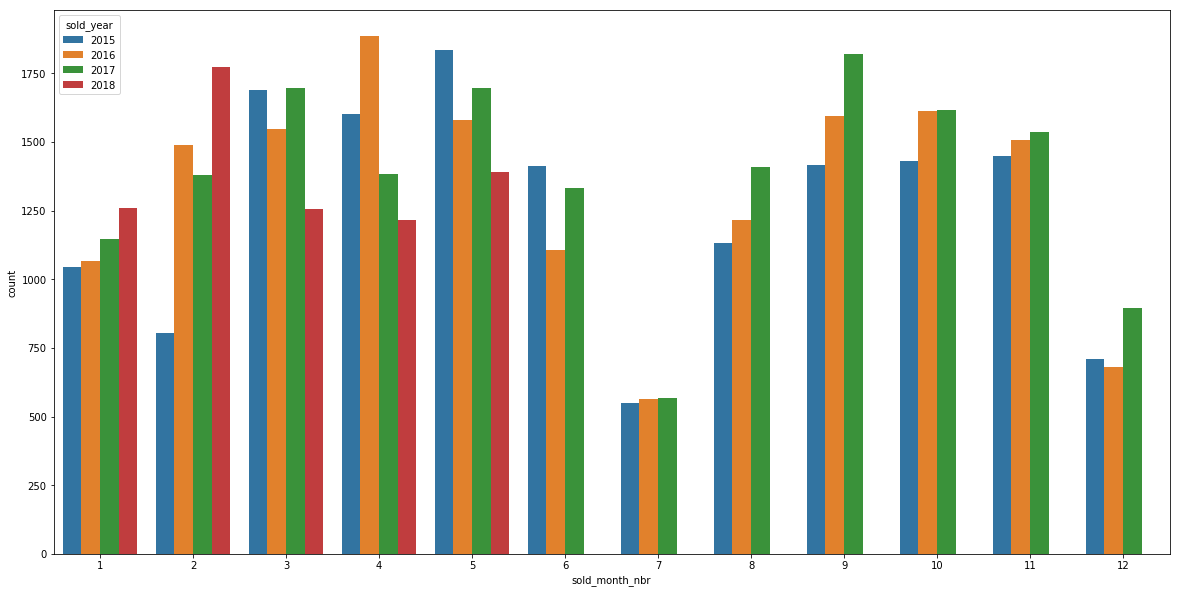

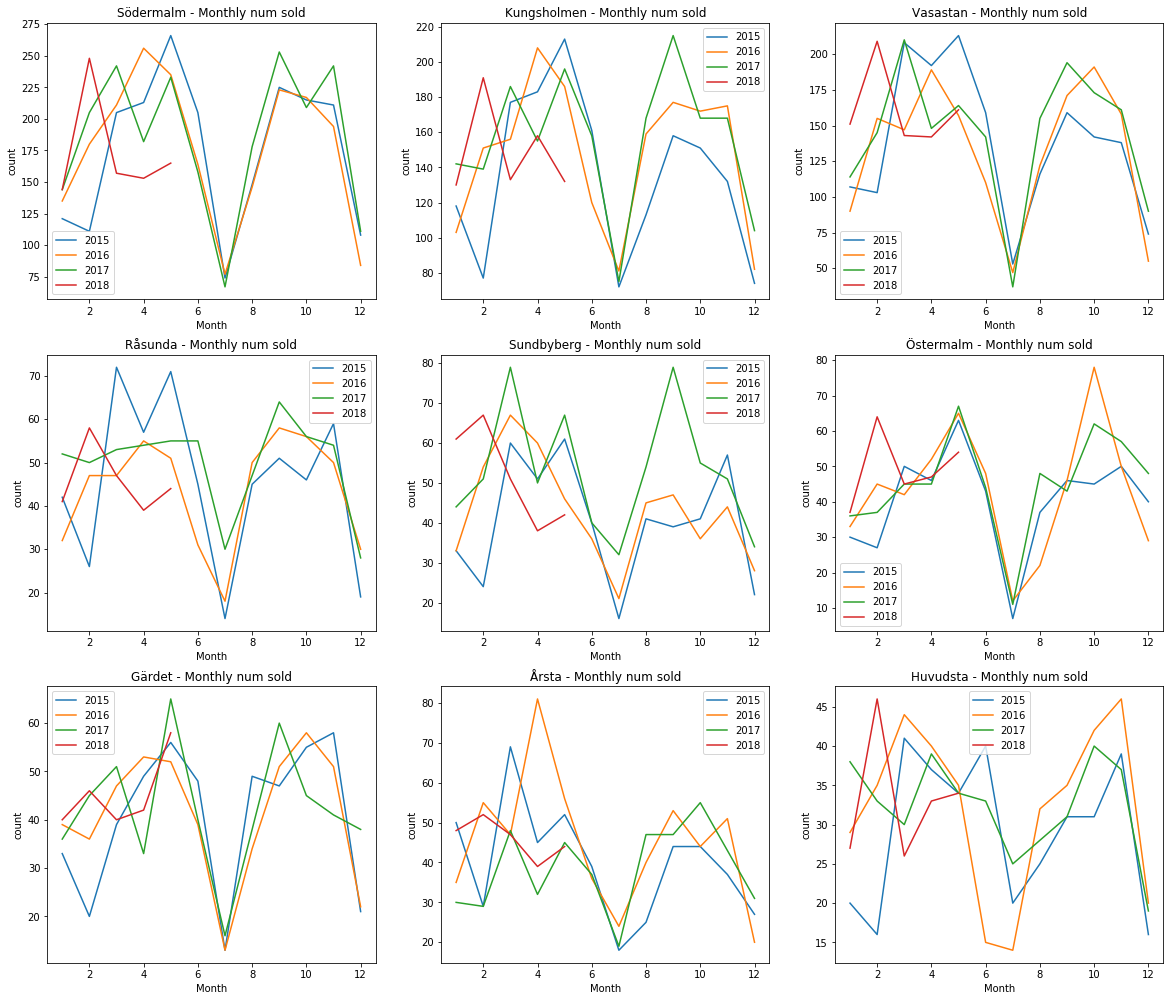

In [432]:
#plt.subplots(figsize=(20,20))
#plt.subplot(2,2,1)
#timeseries_plot(clean.groupby(['week','year']).count()['sqm_price'].unstack(),"All Areas - Weekly num sold", "Week", "num sold")
#plt.subplot(2,2,2)
#timeseries_plot(clean.groupby(['sold_month_nbr','sold_year']).count()['sqm_price'].unstack(),"All Areas - Monthly num sold", "Month", "num sold")
plt.subplots(figsize=(20,10))
sns.countplot(x="sold_month_nbr", hue="sold_year", data=clean)

areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    
    plot_data = clean[(clean.area_from_geo == areas[i])].groupby(['sold_month_nbr','sold_year']).count()['sqm_price'].unstack()
    #sns.countplot(x="sold_month_nbr", hue="sold_year", data=clean[(clean.area_from_geo == areas[i])])
    #plot_data = clean[(clean.area_from_geo == areas[i]) & (clean.living_area < 65) & (clean.living_area > 30) ].groupby(['month_nbr','year']).count()['sqm_price'].unstack()
    timeseries_plot(plot_data, areas[i] + " - Monthly num sold", "Month", "count")
    
plt.show()



## Box Plots


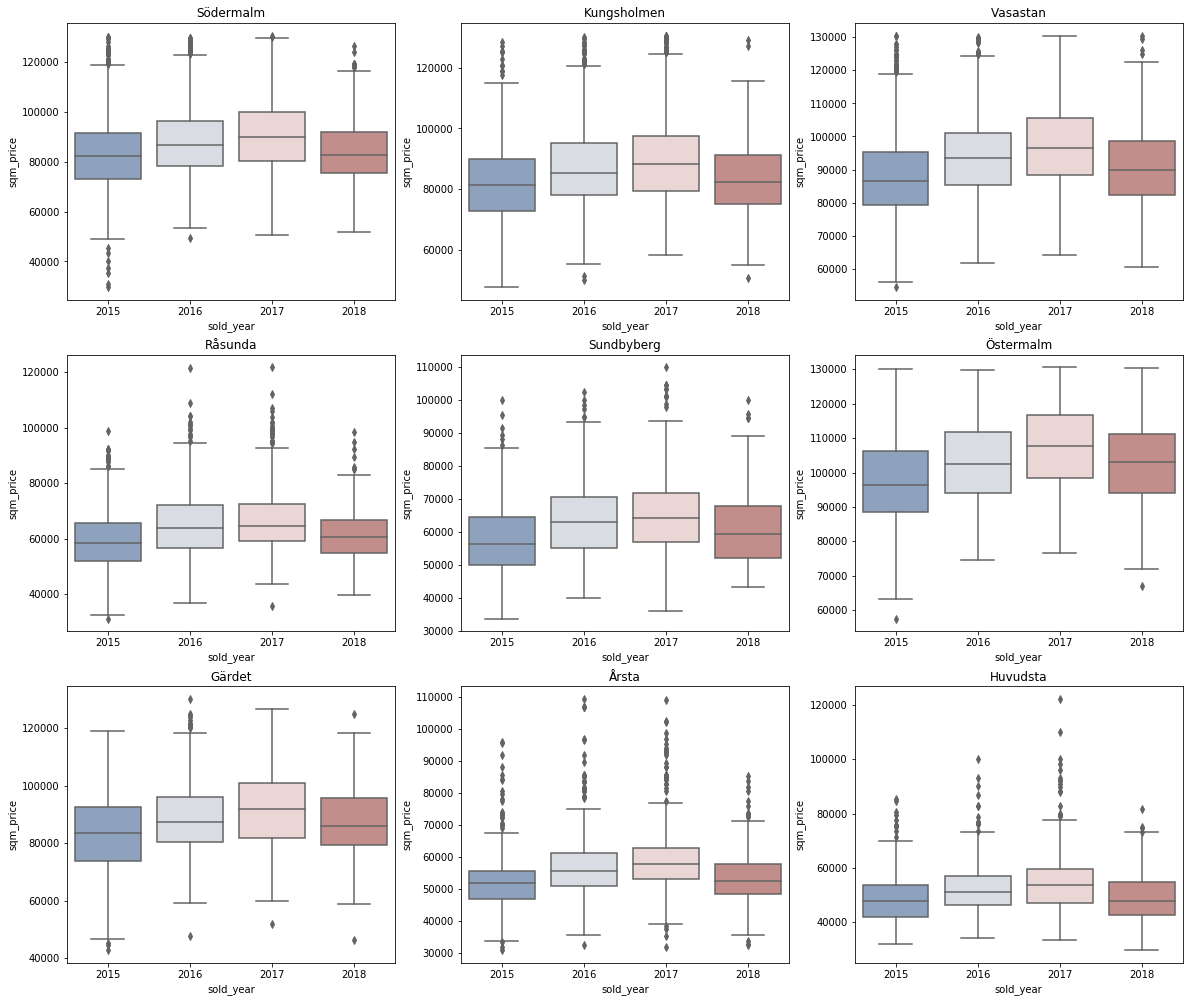

In [433]:
# top 10 areas:
areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
#print(hej)
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    sns.boxplot(x="sold_year", y="sqm_price", data=clean[(clean.area_from_geo == areas[i])] ,palette="vlag").set_title(areas[i])

plt.show()



## Bivariate Plot

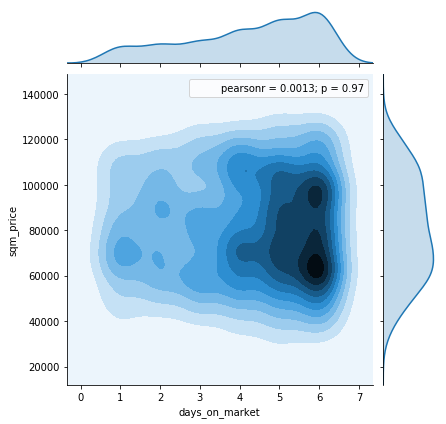

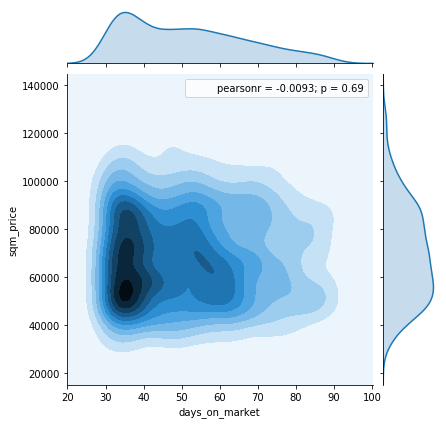

In [436]:
#published weekday
#sns.jointplot(x="published_weekday", y="sqm_price", data=clean[(clean['sold_year'] == 2017) ], kind="kde")

# days on market
sns.jointplot(x="days_on_market", y="sqm_price", data=clean[(clean['days_on_market'] < 7) & (clean['sold_year'] == 2017) ], kind="kde");
sns.jointplot(x="days_on_market", y="sqm_price", data=clean[(clean['days_on_market'] > 30)& (clean['days_on_market'] < 90) & (clean['sold_year'] == 2017) ], kind="kde");

## contruction year vs (price/rent)
#sns.jointplot(x="construction_year", y="sqm_rent", data=clean, kind="kde");
#sns.jointplot(x="construction_year", y="sqm_price", data=clean, kind="kde");


#sns.jointplot(x="sqm_rent", y="sqm_price", data=clean, kind="kde");
#sns.jointplot(x="min_distance_to_metro", y="sqm_price", data=clean, kind="kde");
plt.show()

# not so nice
#sns.jointplot(x="month_nbr", y="sqm_price", data=clean, kind="kde");

In [217]:
''

''

In [419]:
#clean.groupby(['sold_month_nbr','sold_year']).mean()['sqm_price'].unstack()

In [418]:
#gammas = sns.load_dataset("gammas")
#gammas
#ax = sns.tsplot(time="sold_month_nbr", value="sqm_price",
#                 unit="sold_year", condition="area_from_geo",
#                data=clean.head(100))
hej = (clean.groupby(['area_from_geo','sold_month_nbr','sold_year']).mean()['sqm_price']).to_frame()
#hej.reset_index(inplace=True)
#hej.columns = np.arange(len(hej.columns))
#melted = pd.melt(hej, id_vars=0)
#sns.tsplot(data=hej, time="sold_month_nbr", unit="sold_year",
#           condition="area_from_geo", value="sqm_price")

#hej.reset_index()
#hej.dropna()
#data.reset_index(inplace=True)
#data.columns = np.arange(len(data.columns))
#melted = pd.melt(data, id_vars=0)
''

#sns.tsplot(data=hej, time="sold_month_nbr", unit="sold_year",
#           condition="area_from_geo", value="sqm_price")

''

In [425]:
#clean.groupby(['sold_month_nbr','sold_year']).count()['sqm_price'].unstack()
plt.subplots(figsize=(20,10))
sns.countplot(x="sold_month_nbr", hue="sold_year", data=clean)
#sns.barplot(x='sold_month_nbr',data=clean.groupby(['sold_month_nbr','sold_year']).count()['sqm_price'].unstack())
#plt.show()